# Food Images Classification

## DS-telecom-14 - Applied Deep Learning with Python (2021-2022)
<blockquote> 
Alexandre PERBET<br>
Cyril NERIN<br>
Hugo RIALAN<br>
</blockquote>

<p><b>The objective of the project is to identify the name of a food recipe from a photo.</b></p> 
<p>For this, we use a transfer learning method on a pre-trained CNN model whose performance is evaluated with the "accuracy" metric.</p> 
<p>We use the Food-101 dataset available in Kaggle which contains 101000 tagged images of food which are distributed in 101 classes. (<a href= https://www.kaggle.com/kmader/food41>https://www.kaggle.com/kmader/food41</a>). </p>
<p>After testing on Kaggle with GPU several pre-trained models, we chose the one that gives the best accuracy value on the validation data.</p>
<p>After tuning the model, we will be able to complete the dataset of food images with photos from other sites (e.g. marmiton) or personal photos.</p>
<p>In a dedicated notebook, we analyze the results obtained by plotting the classification report and the confusion matrix and by visualizing some images of correctly recognized food and some images not recognized by the model. We try to understand why some images are misclassified.</p>
<p>We also plan to develop a <b>demo web-app</b> to test our best model on new images.
<p>Our project answers <b>two use cases</b>: the model could be used to make focused advertising (restaurant, pastry chef ... ) from the analysis of food images posted on social networks or it could be used in a dedicated application available on smartphone that would give the name and the recipe of a dish from a photo.</p>

In [1]:
import os
import shutil

# Notebook settings

In [2]:
# Reduced data set for the development stage
reduced_dataset = False

classes_to_keep = ['beef_tartare', 'hamburger', 'panna_cotta', 'pizza']

# Image size
img_height = 224
img_width = 224
channel = 3

# Run locally on the laptop or run on Kaggle to take advantage of the GPU
running_on_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') != 'Localhost'

# Training parameters 
batch_size = 32
epochs = 20

In [3]:
if running_on_kaggle:
    print('Kaggle environment detected')
    # !nvidia-smi
    data_dir = '/kaggle/input/food41/images/'
    if reduced_dataset:
        # Select few classes for the development stage
        try:
            shutil.copytree(data_dir + elt,'/kaggle/temp/images_kept/' + elt)
        except:
            print("class ", elt, "already copied !")
        data_dir = '/kaggle/temp/images_kept/'
else:
    print('Running on localhost')
    data_dir = './dataset/food/images/'
    !pip install --quiet -r requirements.txt
    !python download_data.py
    if reduced_dataset:
        # Select few classes for the development stage
        for elt in classes_to_keep:
            shutil.copytree(data_dir + elt,'./dataset/food/images_kept/' + elt, dirs_exist_ok=True)
        data_dir = './dataset/food/images_kept/'

Kaggle environment detected


# Libraries

In [4]:
import sys 
print("Python version: {}". format(sys.version))

import IPython
from IPython import display
from IPython.display import Markdown, display
print("IPython version: {}". format(IPython.__version__))

import numpy as np
print("NumPy version: {}". format(np.__version__))

import scipy as sp
from scipy import stats
print("SciPy version: {}". format(sp.__version__))

import pandas as pd
print("pandas version: {}". format(pd.__version__))

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

import seaborn as sns
print("seaborn version : {}". format(sns.__version__))
sns.set()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
print("tensorflow version : {}". format(tf.__version__))

Python version: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
IPython version: 7.30.1
NumPy version: 1.20.3
SciPy version: 1.7.3
pandas version: 1.3.5
matplotlib version: 3.5.1
seaborn version : 0.11.2
tensorflow version : 2.6.2


# Load the data

In [5]:
train_data = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    image_size=(img_height, img_width),
    batch_size= batch_size,
    shuffle = True,
    subset='training',
    seed = 123,
    label_mode = 'categorical',
)

val_data = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    image_size=(img_height, img_width),
    batch_size= batch_size,
    shuffle = False,
    subset='validation',
    seed = 123,
    label_mode = 'categorical',
)

print(len(train_data))
print(len(val_data))

Found 101000 files belonging to 101 classes.
Using 80800 files for training.


2022-03-19 17:18:36.296171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 17:18:36.402763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 17:18:36.403889: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 17:18:36.407424: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 101000 files belonging to 101 classes.
Using 20200 files for validation.
2525
632


In [6]:
class_names = train_data.class_names
number_of_classes = len(class_names)
print("{} classes of food are detected: {}".format(number_of_classes, class_names))

101 classes of food are detected: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_

## Train data

2022-03-19 17:18:42.247185: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


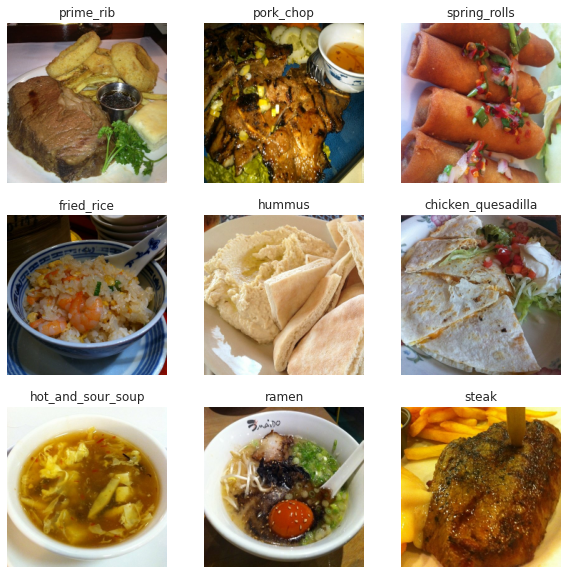

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i].numpy())])
        plt.axis("off")

## Validation data

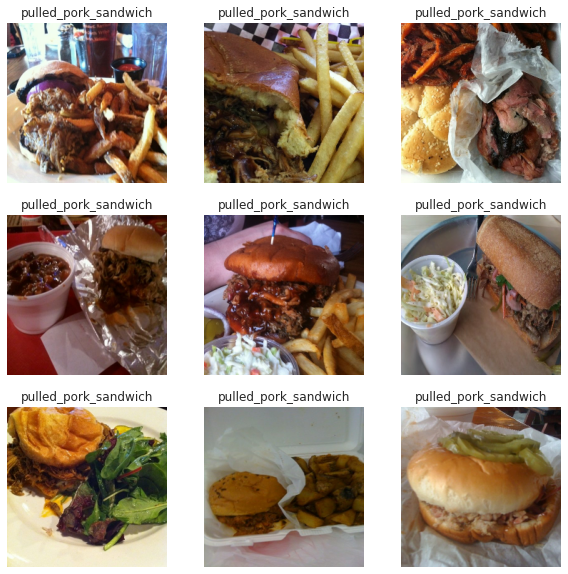

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in val_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i].numpy())])
        plt.axis("off")

## Rescaling the data

In [9]:
resize_and_rescale = keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_height, img_width),
  layers.experimental.preprocessing.Rescaling(1 /255)
])

## Data augmentation

In [10]:
# Data augmentation to reduce overtraining
data_augmentation = keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height,
                                                              img_width,
                                                              channel)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

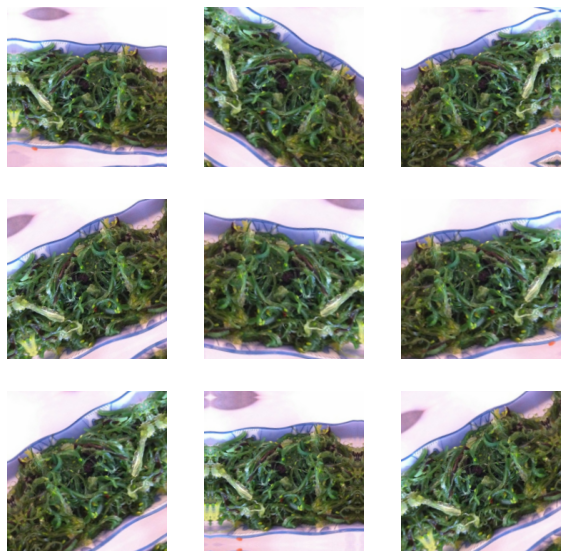

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(100):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Building the model : Transfert Learning using EfficientNetB0

In [12]:
model = keras.Sequential([
        #resize_and_rescale,
        data_augmentation,
        keras.applications.EfficientNetB0(
            input_shape=(img_height, img_width, channel),
            weights='imagenet',
            include_top=False,
            drop_connect_rate=0.5
        ),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(number_of_classes, activation='softmax')
])

16719872/16705208 [==============================] - 1s 0us/step


In [13]:
model.compile(loss='categorical_crossentropy', 
              optimizer="adam",
              metrics=['accuracy'])

# Train the model

In [14]:

history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/20


2022-03-19 17:19:47.742048: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2525/2525 [==============================] - 711s 274ms/step - loss: 1.7671 - accuracy: 0.5505 - val_loss: 1.5489 - val_accuracy: 0.5934
Epoch 2/20
2525/2525 [==============================] - 715s 283ms/step - loss: 1.2170 - accuracy: 0.6772 - val_loss: 1.3123 - val_accuracy: 0.6439
Epoch 3/20
2525/2525 [==============================] - 711s 281ms/step - loss: 1.0485 - accuracy: 0.7182 - val_loss: 1.2709 - val_accuracy: 0.6623
Epoch 4/20
2525/2525 [==============================] - 710s 281ms/step - loss: 0.9425 - accuracy: 0.7418 - val_loss: 1.0063 - val_accuracy: 0.7310
Epoch 5/20
2525/2525 [==============================] - 715s 283ms/step - loss: 0.8546 - accuracy: 0.7651 - val_loss: 0.9889 - val_accuracy: 0.7362
Epoch 6/20
2525/2525 [==============================] - 716s 283ms/step - loss: 0.7811 - accuracy: 0.7816 - val_loss: 0.8414 - val_accuracy: 0.7649
Epoch 7/20
2525/2525 [==============================] - 706s 279ms/step - loss: 0.7162 - accuracy: 0.7969 - val_loss: 0.781

## Plot the results

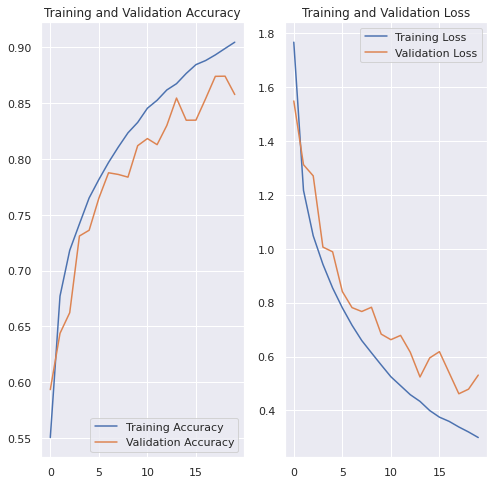

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Save the trained model

In [16]:
if running_on_kaggle:
    model.save('/kaggle/working/efficientnetb0_model_2')
    model.save_weights("/kaggle/working/saved_efficientnetb0_model_2.h5")
else:
    model.save("./efficientnetb0_model")
    model.save_weights("./saved_model3_weights/saved_efficientnetb0_model.h5")

2022-03-19 21:25:35.451481: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
